# Team as an entity model

This model is a

In [10]:
# Import
from torch import nn
from torch.utils.data import DataLoader, random_split

from models.models import *
from datasets.datasets import *
from utils import *

In [11]:
# Meta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


# Dataset

In [3]:
dataset = get_player_dataset()

[250.95715528  26.41576048  47.80955488   7.7646803   13.03414528
  20.79882558  -0.45635784  36.71190373   2.35656807   5.61903726
   1.87277077   0.27287226   1.18123822   9.20675656   3.54654197
   0.28084674  79.81955923]
[144.43579635   4.34517805  28.32239301   9.19750169  13.6573494
  21.62137906  10.12232787  42.12998753   2.74911337   6.3513269
   3.27577955   0.72091061   1.73244639   8.66388769   5.97392126
   0.67312371  70.84096832]


# Dataloader

In [12]:
batch_size = 100
test_length = len(dataset)//10
train_length = len(dataset) - test_length

print(test_length)
print(train_length)
dataset_test, dataset_train = random_split(dataset, [test_length, train_length])


# Must generate batches of sequence data with the following format:
# (batch_size, num_seasons(N), input_size(num stats))
# (https://stackoverflow.com/questions/49466894/how-to-correctly-give-inputs-to-embedding-lstm-and-linear-layers-in-pytorch/49473068#49473068)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

print(dataset_train.__getitem__(0))

359
3231
(tensor([[ 1.0319, -0.7861, -0.7347, -0.6268, -0.6615, -0.6845, -0.4489, -0.6815,
         -0.8208, -0.7273, -0.2664, -0.3785, -0.6818, -0.7164, -0.4263, -0.4172,
         -0.6044],
        [ 0.9904, -0.5560, -0.2757,  0.0256, -0.5883, -0.3607, -0.7452, -0.6815,
         -0.4571,  0.2174, -0.2664, -0.3785, -0.1046, -0.6010, -0.4263, -0.4172,
         -0.4633],
        [ 1.0873, -0.3258, -0.8760,  0.2430, -0.5150, -0.2219,  0.1439, -0.8239,
         -0.0933,  0.2174, -0.2664,  2.3958,  1.0498, -0.6010, -0.2589, -0.4172,
         -0.5762],
        [ 1.1565, -0.0957,  1.0306,  2.0914,  0.3636,  1.1193, -0.1525, -0.2068,
          1.0343,  2.4217,  1.2599, -0.3785,  1.6270,  0.5532, -0.0915,  1.0684,
          1.0330],
        [ 1.3088,  0.1345,  0.8541,  1.3303,  0.2904,  0.7493, -0.7452, -0.1118,
          0.7069,  1.6345,  0.3441,  1.0086,  2.2043,  0.5532, -0.0915, -0.4172,
          0.7931]]), tensor([ 1.2188,  0.3646, -0.5229, -0.5180, -0.5150, -0.5457, -1.0416, -0.7290,
   

# Training and Validation

In [13]:
# NOTE: N will be variable, as the input size
input_size = len(dataset_train.__getitem__(0)[0][0])
print(f"Input size: {input_size}")
hidden_size = 5
model = PlayerStandalone(input_size=input_size, hidden_size=hidden_size, device=device).to(device)

Input size: 17


In [14]:
criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 500
loss_interval = 25

In [15]:
(model, train_losses, val_losses) = train_and_validate(model, criterion, optimizer, dataloader_train, dataloader_test, epochs=epochs, loss_interval=loss_interval, device=device)

0 th epoch :  1.0129159905693748
Validation loss for epoch 0: 0.9791950434446335
Validation loss for epoch 25: 0.784990131855011
50 th epoch :  0.75418308467576
Validation loss for epoch 50: 0.7677379101514816
Validation loss for epoch 75: 0.7660548537969589
100 th epoch :  0.7406481648936416
Validation loss for epoch 100: 0.7571868002414703
Validation loss for epoch 125: 0.7448050081729889
150 th epoch :  0.7270920619820104
Validation loss for epoch 150: 0.752534806728363
Validation loss for epoch 175: 0.7493304014205933
200 th epoch :  0.7252229434071165
Validation loss for epoch 200: 0.7502905130386353
Validation loss for epoch 225: 0.7551666051149368
250 th epoch :  0.7204546242049246
Validation loss for epoch 250: 0.7501063048839569
Validation loss for epoch 275: 0.7384463399648666
300 th epoch :  0.7178059075817917
Validation loss for epoch 300: 0.7556218653917313
Validation loss for epoch 325: 0.7464161962270737
350 th epoch :  0.7118354241053263
Validation loss for epoch 350: 0

In [16]:
#average results
avg_predictions = []
avg_targets = []
for step, (x,y) in enumerate(dataset_train):
    for i in range(len(x)):
        avg_predictions.append(torch.mean(x, dim=0)) 
        avg_targets.append(y)

avg_predictions = torch.stack(avg_predictions)
avg_targets = torch.stack(avg_targets)
avg_loss = criterion(avg_predictions, avg_targets)

# Plot Results

Average loss: 0.8362852334976196


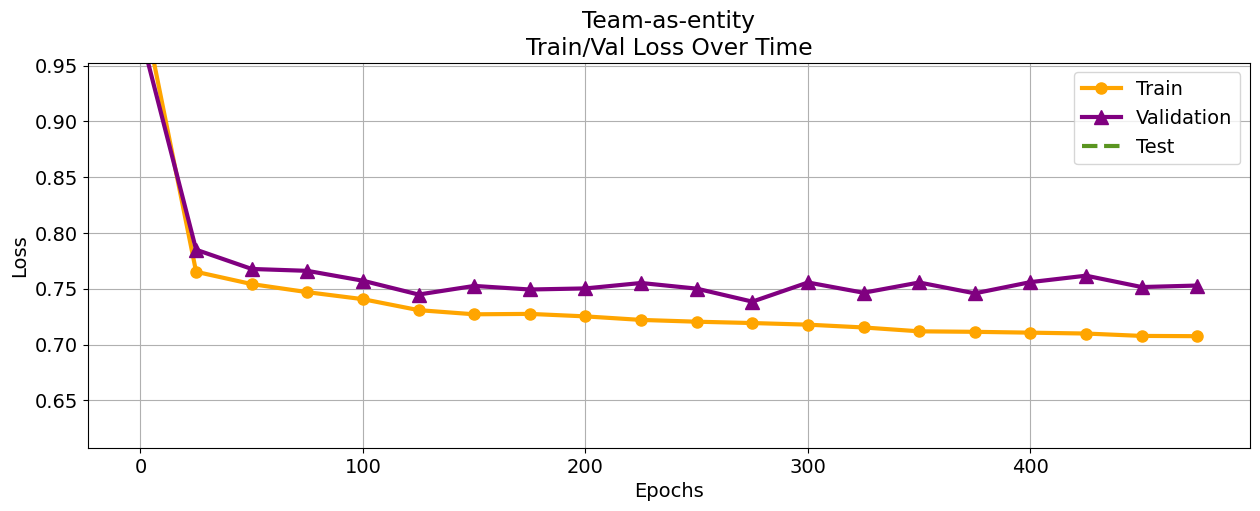

In [17]:
print(f"Average loss: {avg_loss}")
plot_train_v_loss(train_losses, val_losses, loss_interval)


In [18]:
# Define loss
def Ind_RMSELoss(yhat, y):
    return torch.sqrt(torch.mean(yhat-y,axis=0)**2)

In [30]:
avg_loss_ind = Ind_RMSELoss(avg_predictions, avg_targets)
print(f"Average loss individual: {avg_loss_ind}")

sample =dataset_train.__getitem__(0)
print(dataset.unnormalize(sample[1]))

pred_sample = model(sample[0].unsqueeze(0).to(device))
print(dataset.unnormalize(pred_sample.cpu().detach()))

Average loss individual: tensor([0.0615, 0.6903, 0.1058, 0.1533, 0.1433, 0.1557, 0.0538, 0.1724, 0.1363,
        0.1421, 0.1329, 0.1002, 0.1181, 0.1297, 0.1295, 0.0887, 0.1474])
tensor([ 4.2700e+02,  2.8000e+01,  3.3000e+01,  3.0000e+00,  6.0000e+00,
         9.0000e+00, -1.1000e+01,  6.0000e+00, -1.0000e-01,  2.0000e+00,
         1.0000e+00,  3.0132e-09,  2.0000e+00,  6.0000e+00,  1.5891e-07,
        -4.9425e-09,  6.2000e+01], dtype=torch.float64)
tensor([[ 4.3404e+02,  2.7351e+01,  6.4999e+01,  1.6052e+01,  1.7480e+01,
          3.3382e+01, -3.3631e-02,  2.6803e+01,  3.4773e+00,  1.1775e+01,
          3.7080e+00,  5.7609e-01,  2.3804e+00,  1.3510e+01,  3.5056e+00,
          3.1309e-01,  1.4074e+02]], dtype=torch.float64)
